## Importing the packages

In [1]:
# General packages
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os

# NLP packages
import nltk
from nltk import word_tokenize
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from wordcloud import WordCloud

# Modeling packages
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score

from sklearn.preprocessing import LabelEncoder
from pylab import rcParams
import warnings
warnings.filterwarnings("ignore")
rcParams['figure.figsize'] = 14, 6
plt.style.use('ggplot')

## Reading the Dataset

In [2]:
amazon_reviews = pd.read_csv(r'C:\Users\Ammu\Desktop\Customer_Reviews (1).csv')
amazon_reviews.head()

,ProductID,UserID,Profile_Name,Helpful_Votes,Total_Votes,Rating,Headline,Review
0,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,3,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,"""Delight"" says it all",This is a confection that has been around a fe...
3,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,Cough Medicine,If you are looking for the secret ingredient i...
4,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,Great taffy,Great taffy at a great price. There was a wid...


In [3]:
amazon_reviews.shape

(10000, 8)

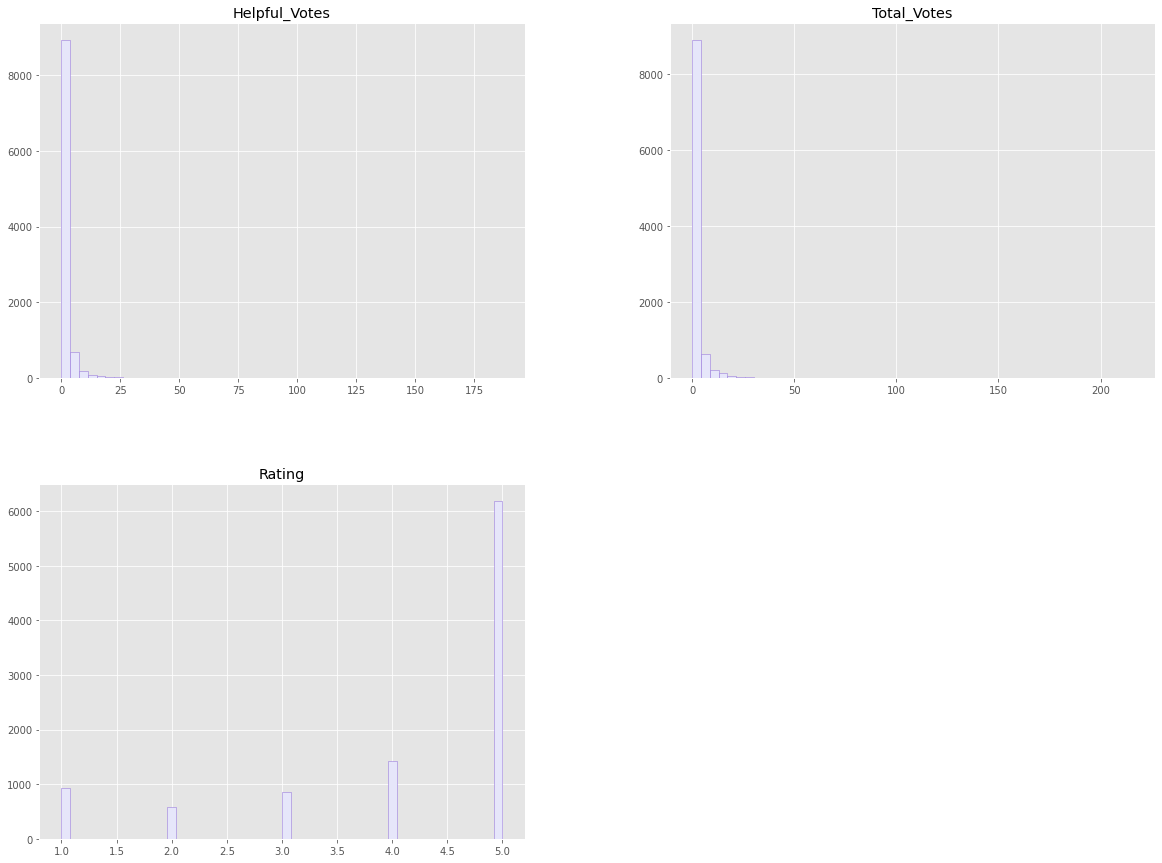

In [36]:
amazon_reviews.hist(bins=50, figsize=(20,15), edgecolor="mediumpurple", color="lavender") # builds histogram and set the number of bins and fig size (width, height)
plt.show()

## Distribution of words per review

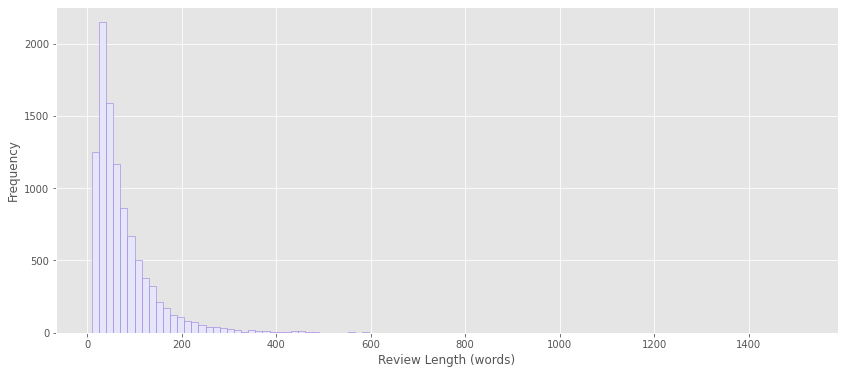

In [41]:
## Getting the number of words by splitting them by a space
words_per_review = amazon_reviews.Review.apply(lambda x: len(x.split(" ")))
words_per_review.hist(bins = 100, edgecolor="mediumpurple", color="lavender")
plt.xlabel('Review Length (words)')
plt.ylabel('Frequency')
plt.show()

In [6]:
print('Average words:', words_per_review.mean())
print('Skewness:', words_per_review.skew())

Average words: 77.9028
Skewness: 4.612459483340116


## Distribution of ratings

In [7]:
percent_val = 100 * amazon_reviews['Rating'].value_counts()/len(amazon_reviews)
percent_val

5    61.82
4    14.33
1     9.32
3     8.63
2     5.90
Name: Rating, dtype: float64

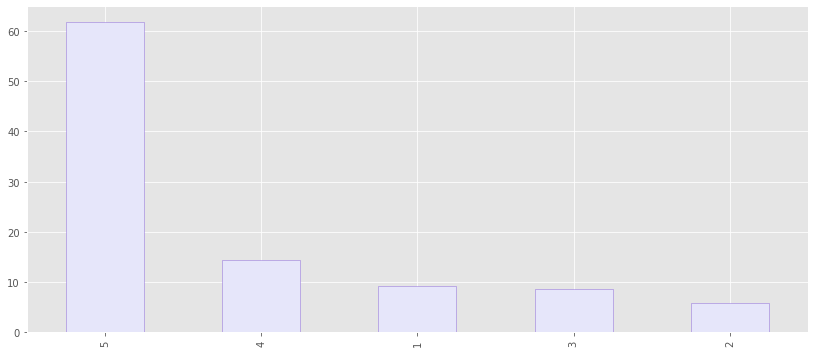

In [35]:
percent_val.plot.bar(edgecolor="mediumpurple", color="lavender")
plt.show()

## Text Visualization using wordcloud 

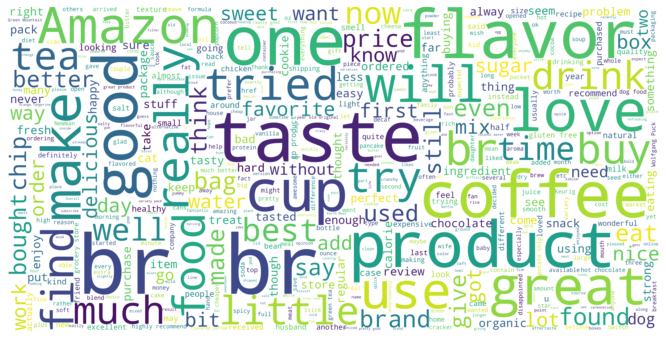

In [9]:
word_cloud_text = ''.join(amazon_reviews['Review'])

wordcloud = WordCloud(max_font_size=100, # Maximum font size for the largest word
                      max_words=500, # The maximum number of words
                      background_color="white", # Background color for the word cloud image
                      scale = 10, # Scaling between computation and drawing
                      width=800, # Width of the canvas
                      height=400 # Height of the canvas
                     ).generate(word_cloud_text)

plt.figure()
plt.imshow(wordcloud, 
           interpolation="bilinear") # to make the displayed image appear more smoothly
plt.axis("off")
plt.show()

## Standardizing the ratings for sentiment analysis

For the purposes of sentiment analysis, all of the ratings are converted into binary values: 
- Ratings of 4 or 5 will get classified to positive 
- Ratings of 1 or 2 will get classified to negative
- Ratings of 3 will get classified to neutral

In [10]:
def sentiments(rating):
    if (rating == 5) or (rating == 4):
        return "Positive"
    elif rating == 3:
        return "Neutral"
    elif (rating == 2) or (rating == 1):
        return "Negative"

# Mapping the ratings
amazon_reviews['Sentiment_Rating'] = amazon_reviews['Rating'].apply(sentiments)
print(amazon_reviews['Sentiment_Rating'])

## Removing neutral reviews 
#amazon_reviews = amazon_reviews[amazon_reviews.Rating != 3]

# Printing the counts of each class
amazon_reviews['Sentiment_Rating'].value_counts()

0        Neutral
1       Negative
2       Positive
3       Negative
4       Positive
          ...   
9995    Negative
9996    Positive
9997    Positive
9998    Positive
9999    Positive
Name: Sentiment_Rating, Length: 10000, dtype: object


Positive    7615
Negative    1522
Neutral      863
Name: Sentiment_Rating, dtype: int64

In [11]:
z=pd.DataFrame(amazon_reviews['Sentiment_Rating'])
z

,Sentiment_Rating
0,Neutral
1,Negative
2,Positive
3,Negative
4,Positive
...,...
9995,Negative
9996,Positive
9997,Positive
9998,Positive


<AxesSubplot:ylabel='Sentiment_Rating'>

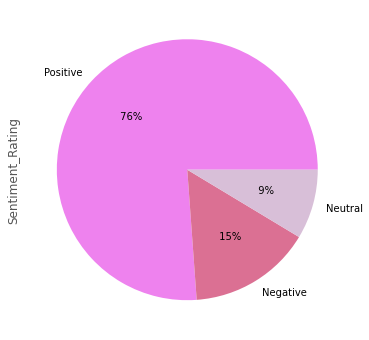

In [34]:
z.Sentiment_Rating.value_counts().plot(kind='pie', autopct='%3.0f%%', colors=["violet", "palevioletred", "thistle"])

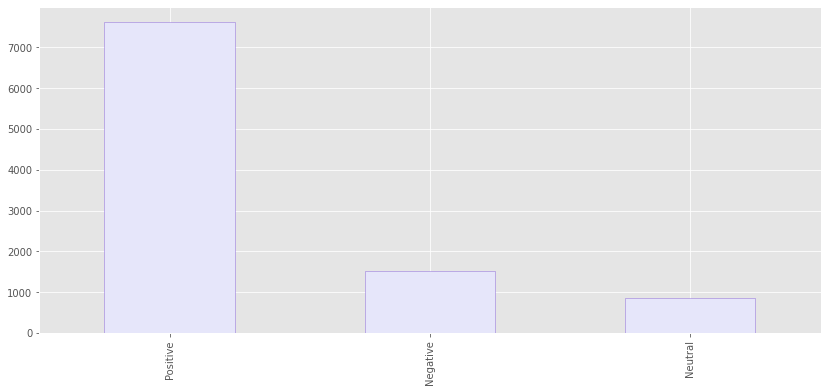

In [33]:
amazon_reviews.Sentiment_Rating.value_counts().plot.bar(edgecolor="mediumpurple", color="lavender")
plt.show()

## Pre processing data

#### Converting words to lower/upper case

In [14]:
amazon_reviews['reviews_text_new'] = amazon_reviews['Review'].str.lower()

In [15]:
from nltk import word_tokenize
# For reviews not converted to lower case
token_lists = [word_tokenize(each) for each in amazon_reviews['Review']]
tokens = [item for sublist in token_lists for item in sublist]
print("Number of unique tokens then: ",len(set(tokens)))

# For reviews converted to lower case
token_lists_lower = [word_tokenize(each) for each in amazon_reviews['reviews_text_new']]
tokens_lower = [item for sublist in token_lists_lower for item in sublist]
print("Number of unique tokens now: ",len(set(tokens_lower)))

Number of unique tokens then:  28992
Number of unique tokens now:  23693


#### Removing special characters

In [16]:
### Selecting non alpha numeric charactes that are not spaces
spl_chars = amazon_reviews['reviews_text_new'].apply(lambda review: 
                                                     [char for char in list(review) if not char.isalnum() and char != ' '])

## Getting list of list into a single list
flat_list = [item for sublist in spl_chars for item in sublist]

## Unique special characters
set(flat_list)

{'!',
 '"',
 '#',
 '$',
 '%',
 '&',
 "'",
 '(',
 ')',
 '*',
 '+',
 ',',
 '-',
 '.',
 '/',
 ':',
 ';',
 '<',
 '=',
 '>',
 '?',
 '@',
 '[',
 ']',
 '^',
 '_',
 '`',
 '{',
 '}',
 '~',
 '¢',
 '§',
 '®'}

In [17]:
review_backup = amazon_reviews['reviews_text_new'].copy()
amazon_reviews['reviews_text_new'] = amazon_reviews['reviews_text_new'].str.replace(r'[^A-Za-z0-9 ]+', ' ')

In [18]:
print("- Old Review -")
print(review_backup.values[6])
print("\n- New Review -")
print(amazon_reviews['reviews_text_new'][6])

- Old Review -
this saltwater taffy had great flavors and was very soft and chewy.  each candy was individually wrapped well.  none of the candies were stuck together, which did happen in the expensive version, fralinger's.  would highly recommend this candy!  i served it at a beach-themed party and everyone loved it!

- New Review -
this saltwater taffy had great flavors and was very soft and chewy   each candy was individually wrapped well   none of the candies were stuck together  which did happen in the expensive version  fralinger s   would highly recommend this candy   i served it at a beach themed party and everyone loved it 


In [19]:
token_lists = [word_tokenize(each) for each in amazon_reviews['Review']]
tokens = [item for sublist in token_lists for item in sublist]
print("Number of unique tokens then: ",len(set(tokens)))

token_lists = [word_tokenize(each) for each in amazon_reviews['reviews_text_new']]
tokens = [item for sublist in token_lists for item in sublist]
print("Number of unique tokens now: ",len(set(tokens)))

Number of unique tokens then:  28992
Number of unique tokens now:  18817


#### Stopwords

In [20]:
from nltk.corpus import stopwords

print('Available languages for NLTK v.3.4.5: ')
print(stopwords.fileids())

Available languages for NLTK v.3.4.5: 
['arabic', 'azerbaijani', 'bengali', 'danish', 'dutch', 'english', 'finnish', 'french', 'german', 'greek', 'hungarian', 'indonesian', 'italian', 'kazakh', 'nepali', 'norwegian', 'portuguese', 'romanian', 'russian', 'slovene', 'spanish', 'swedish', 'tajik', 'turkish']


In [21]:
noise_words = []
eng_stop_words = stopwords.words('english')
eng_stop_words

['i',
 'me',
 'my',
 'myself',
 'we',
 'our',
 'ours',
 'ourselves',
 'you',
 "you're",
 "you've",
 "you'll",
 "you'd",
 'your',
 'yours',
 'yourself',
 'yourselves',
 'he',
 'him',
 'his',
 'himself',
 'she',
 "she's",
 'her',
 'hers',
 'herself',
 'it',
 "it's",
 'its',
 'itself',
 'they',
 'them',
 'their',
 'theirs',
 'themselves',
 'what',
 'which',
 'who',
 'whom',
 'this',
 'that',
 "that'll",
 'these',
 'those',
 'am',
 'is',
 'are',
 'was',
 'were',
 'be',
 'been',
 'being',
 'have',
 'has',
 'had',
 'having',
 'do',
 'does',
 'did',
 'doing',
 'a',
 'an',
 'the',
 'and',
 'but',
 'if',
 'or',
 'because',
 'as',
 'until',
 'while',
 'of',
 'at',
 'by',
 'for',
 'with',
 'about',
 'against',
 'between',
 'into',
 'through',
 'during',
 'before',
 'after',
 'above',
 'below',
 'to',
 'from',
 'up',
 'down',
 'in',
 'out',
 'on',
 'off',
 'over',
 'under',
 'again',
 'further',
 'then',
 'once',
 'here',
 'there',
 'when',
 'where',
 'why',
 'how',
 'all',
 'any',
 'both',
 'each

In [22]:
stop_words = set(eng_stop_words)
without_stop_words = []
stopword = []
sentence = amazon_reviews['reviews_text_new'][0]
words = nltk.word_tokenize(sentence)

for word in words:
    if word in stop_words:
        stopword.append(word)
    else:
        without_stop_words.append(word)

print('-- Original Sentence --\n', sentence)
print('\n-- Stopwords in the sentence --\n', stopword)
print('\n-- Non-stopwords in the sentence --\n', without_stop_words)

-- Original Sentence --
 i have bought several of the vitality canned dog food products and have found them all to be of good quality  the product looks more like a stew than a processed meat and it smells better  my labrador is finicky and she appreciates this product better than  most 

-- Stopwords in the sentence --
 ['i', 'have', 'of', 'the', 'and', 'have', 'them', 'all', 'to', 'be', 'of', 'the', 'more', 'a', 'than', 'a', 'and', 'it', 'my', 'is', 'and', 'she', 'this', 'than', 'most']

-- Non-stopwords in the sentence --
 ['bought', 'several', 'vitality', 'canned', 'dog', 'food', 'products', 'found', 'good', 'quality', 'product', 'looks', 'like', 'stew', 'processed', 'meat', 'smells', 'better', 'labrador', 'finicky', 'appreciates', 'product', 'better']


In [23]:
def stopwords_removal(stop_words, sentence):
    return [word for word in nltk.word_tokenize(sentence) if word not in stop_words]

amazon_reviews['reviews_text_nonstop'] = amazon_reviews['reviews_text_new'].apply(lambda row: stopwords_removal(stop_words, row))
amazon_reviews[['reviews_text_new','reviews_text_nonstop']]

,reviews_text_new,reviews_text_nonstop
0,i have bought several of the vitality canned d...,"[bought, several, vitality, canned, dog, food,..."
1,product arrived labeled as jumbo salted peanut...,"[product, arrived, labeled, jumbo, salted, pea..."
2,this is a confection that has been around a fe...,"[confection, around, centuries, light, pillowy..."
3,if you are looking for the secret ingredient i...,"[looking, secret, ingredient, robitussin, beli..."
4,great taffy at a great price there was a wid...,"[great, taffy, great, price, wide, assortment,..."
...,...,...
9995,we switched from the advance similac to the or...,"[switched, advance, similac, organic, product,..."
9996,like the bad reviews say the organic formula ...,"[like, bad, reviews, say, organic, formula, co..."
9997,i wanted to solely breastfeed but was unable t...,"[wanted, solely, breastfeed, unable, keep, sup..."
9998,i love the fact that i can get this delieved t...,"[love, fact, get, delieved, house, delievy, ch..."


## Extracting features from reviews and Model building

In [24]:
amazon_reviews[['Review','Rating','Sentiment_Rating']].head(5)

,Review,Rating,Sentiment_Rating
0,I have bought several of the Vitality canned d...,3,Neutral
1,Product arrived labeled as Jumbo Salted Peanut...,1,Negative
2,This is a confection that has been around a fe...,4,Positive
3,If you are looking for the secret ingredient i...,2,Negative
4,Great taffy at a great price. There was a wid...,5,Positive


In [25]:
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score

#### TF-IDF 

Extracting features

In [26]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Creating a python object of the class CountVectorizer
tfidf_counts = TfidfVectorizer(tokenizer= word_tokenize, # type of tokenization
                               stop_words=noise_words, # List of stopwords
                               ngram_range=(1,1)) # number of n-grams

In [27]:
tfidf_data = tfidf_counts.fit_transform(amazon_reviews['reviews_text_new'])
tfidf_data

<10000x18817 sparse matrix of type '<class 'numpy.float64'>'
	with 547180 stored elements in Compressed Sparse Row format>

Splitting data into training and testing sets

In [28]:
X_train_tfidf, X_test_tfidf, y_train_tfidf, y_test_tfidf = train_test_split(tfidf_data.toarray(),
                                                                            amazon_reviews['Sentiment_Rating'],
                                                                            test_size = 0.2,
                                                                            random_state = 0)

In [29]:
X_train_tfidf, X_test_tfidf, y_train_tfidf, y_test_tfidf = train_test_split(tfidf_data,
                                                                            amazon_reviews['Sentiment_Rating'],
                                                                            test_size = 0.2,
                                                                            random_state = 0)

In [30]:
from sklearn import svm 
svm_classifier = svm.SVC()
svm_classifier.fit(X_train_tfidf,y_train_tfidf)
svm_pred_tf = svm_classifier.predict(X_test_tfidf)
print(classification_report(svm_pred_tf, y_test_tfidf))
print('Accuracy: {}'. format(accuracy_score(svm_pred_tf, y_test_tfidf)))

              precision    recall  f1-score   support

    Negative       0.38      0.88      0.53       127
     Neutral       0.08      1.00      0.16        15
    Positive       1.00      0.82      0.90      1858

    accuracy                           0.82      2000
   macro avg       0.49      0.90      0.53      2000
weighted avg       0.95      0.82      0.87      2000

Accuracy: 0.824


Applying Logistic Regression

In [31]:
lr_model_tf_idf = LogisticRegression()
lr_model_tf_idf.fit(X_train_tfidf,y_train_tfidf)
test_pred_lr_tf = lr_model_tf_idf.predict(X_test_tfidf)
print(classification_report(test_pred_lr_tf, y_test_tfidf))
print('Accuracy: {}'. format(accuracy_score(test_pred_lr_tf, y_test_tfidf)))

              precision    recall  f1-score   support

    Negative       0.44      0.80      0.57       162
     Neutral       0.13      0.79      0.22        29
    Positive       0.99      0.83      0.91      1809

    accuracy                           0.83      2000
   macro avg       0.52      0.81      0.56      2000
weighted avg       0.93      0.83      0.87      2000

Accuracy: 0.831


KNN

In [32]:
from sklearn.neighbors import KNeighborsClassifier
k=KNeighborsClassifier(n_neighbors=18)
k.fit(X_train_tfidf,y_train_tfidf)

knn_pred_tf = k.predict(X_test_tfidf)
print(classification_report(knn_pred_tf, y_test_tfidf))
print('Accuracy: {}'. format(accuracy_score(knn_pred_tf, y_test_tfidf)))

              precision    recall  f1-score   support

    Negative       0.08      0.81      0.15        31
     Neutral       0.04      0.53      0.08        15
    Positive       1.00      0.78      0.87      1954

    accuracy                           0.78      2000
   macro avg       0.37      0.71      0.37      2000
weighted avg       0.97      0.78      0.86      2000

Accuracy: 0.7755
